![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de árboles de decisión y métodos de ensamblaje

En este taller podrá poner en práctica los sus conocimientos sobre construcción e implementación de árboles de decisión y métodos de ensamblajes. El taller está constituido por 9 puntos, 5 relacionados con árboles de decisión (parte A) y 4 con métodos de ensamblaje (parte B).

## Parte A - Árboles de decisión

En esta parte del taller se usará el conjunto de datos de Capital Bikeshare de Kaggle, donde cada observación representa el alquiler de bicicletas durante una hora y día determinado. Para más detalles puede visitar los siguientes enlaces: [datos](https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip), [dicccionario de datos](https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset#).

### Datos prestamo de bicicletas

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importación de librerías
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, export_graphviz

In [3]:
# Lectura de la información de archivo .csv
bikes = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/bikeshare.csv', index_col='datetime', parse_dates=True)

# Renombrar variable "count" a "total"
bikes.rename(columns={'count':'total'}, inplace=True)

# Crear la hora como una variable 
bikes['hour'] = bikes.index.hour

# Visualización de los datos
bikes.tail()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total,hour
datetime,,,,,,,,,,,,
2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336,19
2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241,20
2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168,21
2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,12,117,129,22
2012-12-19 23:00:00,4,0,1,1,13.12,16.665,66,8.9981,4,84,88,23


### Punto 1 - Análisis descriptivo

Ejecute las celdas 1.1 y 1.2. A partir de los resultados realice un análisis descriptivo sobre las variables "season" y "hour", escriba sus inferencias sobre los datos. Para complementar su análisis puede usar métricas como máximo, mínimo, percentiles entre otros.

In [4]:
# Mínimo, máximo y promedio de alquileres por estación
season_min = bikes.groupby('season')['total'].min().rename('min')
season_max = bikes.groupby('season')['total'].max().rename('max')
season_mean = bikes.groupby('season')['total'].mean().rename('mean')

# Percentiles por estación
percentiles = bikes.groupby('season')['total'].quantile([0.25, 0.50, 0.75]).unstack().rename(columns={0.25: '25%', 0.50: '50%', 0.75: '75%'})

# Concatenar los resultados en un DataFrame
season_stats = pd.concat([season_min, season_max, season_mean, percentiles], axis=1)
print("\nEstadísticas de alquiler de bicicletas por estación:")
print(season_stats)



Estadísticas de alquiler de bicicletas por estación:
        min  max        mean   25%    50%    75%
season                                          
1         1  801  116.343261  24.0   78.0  164.0
2         1  873  215.251372  49.0  172.0  321.0
3         1  977  234.417124  68.0  195.0  347.0
4         1  948  198.988296  51.0  161.0  294.0


En promedio, observamos que la estación 3, correspondiente al verano según el diccionario de datos, es la que registra el mayor número de alquileres de bicicletas, con un promedio de 234 alquileres. Le sigue la estación 2, asociada a la primavera, luego la estación 4 y finalmente la estación 1, correspondientes al otoño e invierno respectivamente.

Es interesante notar que todas las estaciones tienen al menos un alquiler como mínimo, mientras que en verano se registra el máximo de 977 alquileres. Sin embargo, este valor máximo en verano podría considerarse atípico, ya que el percentil del 75% nos indica que el 75% de los días en verano tienen menos de 347 alquileres, lo que sugiere una posible presencia de datos atípicos en este conjunto de datos.

En conclusión podemos inferir que verena por el excelente clima es cuando las personas mas se movilizan en bici, en invierno muchas personas deciden no usar el servicio por lo que cae considerablemente.

In [5]:
# Mínimo, máximo y promedio de alquileres por hora
season_min = bikes.groupby('hour')['total'].min().rename('min')
season_max = bikes.groupby('hour')['total'].max().rename('max')
season_mean = bikes.groupby('hour')['total'].mean().rename('mean')

# Percentiles por hora
percentiles = bikes.groupby('hour')['total'].quantile([0.25, 0.50, 0.75]).unstack().rename(columns={0.25: '25%', 0.50: '50%', 0.75: '75%'})

# Concatenar los resultados en un DataFrame
season_stats = pd.concat([season_min, season_max, season_mean, percentiles], axis=1)
print("\nEstadísticas de alquiler de bicicletas por hora:")
print(season_stats)



Estadísticas de alquiler de bicicletas por hora:
      min  max        mean     25%    50%     75%
hour                                             
0       2  283   55.138462   24.00   41.0   74.50
1       1  168   33.859031   11.00   19.0   46.00
2       1  119   22.899554    5.00   11.0   32.00
3       1   66   11.757506    3.00    6.0   15.00
4       1   28    6.407240    3.00    6.0    9.00
5       1   57   19.767699    8.00   19.0   29.00
6       1  213   76.259341   24.50   75.0  118.00
7       1  596  213.116484   63.00  208.0  334.00
8       8  839  362.769231  133.50  392.0  563.50
9      14  414  221.780220  161.00  217.0  294.50
10     17  539  175.092308  106.00  149.0  218.50
11     10  647  210.674725  123.00  183.0  265.50
12      3  757  256.508772  157.00  234.5  332.00
13     11  729  257.787281  154.00  226.5  329.00
14     12  730  243.442982  144.00  212.0  311.25
15      7  724  254.298246  154.00  232.0  331.00
16     11  783  316.372807  211.75  309.5  421.00


En promedio, observamos que las 17 horas es el momento del día que registra el mayor número de alquileres de bicicletas, con un promedio de aproximadamente 469 alquileres. Le sigue las 18 horas en segundo lugar. Sorprendentemente, a las 4 de la mañana se registra el mínimo de alquileres, con un promedio de solo 6 bicicletas. Este hallazgo es interesante, ya que comúnmente se esperaría que la medianoche fuera la hora con menos actividad. Sin embargo, al analizar más a fondo, parece que muchas personas salen tarde, lo que explica por qué estas horas tempranas de la madrugada tienen tan poca demanda de alquileres.

En conclusión se puede inferir que hay dos momento pico uno en la mañana y otro en la tarde, por lo cual se debe dar al horario comun laboral de la mayoria de personas. Por ende deben ser empleados los que mas usan el servicio. 

### Punto 2 - Análisis de gráficos

Primero ejecute la celda 2.1 y asegúrese de comprender el código y el resultado. Luego, en cada una de celdas 2.2 y 2.3 escriba un código que genere una gráfica del número de bicicletas rentadas promedio para cada valor de la variable "hour" (hora) cuando la variable "season" es igual a 1 (invierno) e igual a 3 (verano), respectivamente. Analice y escriba sus hallazgos.

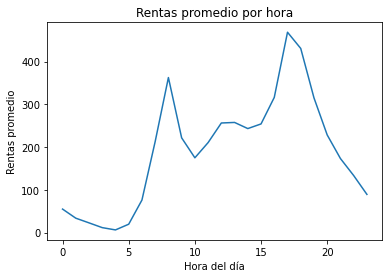

In [6]:
import matplotlib.pyplot as plt

# Celda 2.1 - rentas promedio para cada valor de la variable "hour"
bikes.groupby('hour').total.mean().plot()
plt.title('Rentas promedio por hora')
plt.xlabel('Hora del día')
plt.ylabel('Rentas promedio')
plt.show()

Vemos como tiene tendencias de uso lo que fortalece el analisis descriptivo, vemos como 8 am y 17 y 18 pm se llegan a los picos.

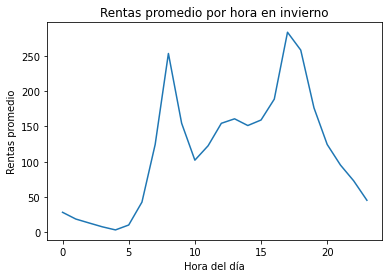

In [7]:
# Celda 2.2 - "season"=1 escriba su código y hallazgos 
bikes[bikes['season'] == 1].groupby('hour').total.mean().plot()
plt.title('Rentas promedio por hora en invierno')
plt.xlabel('Hora del día')
plt.ylabel('Rentas promedio')
plt.show()

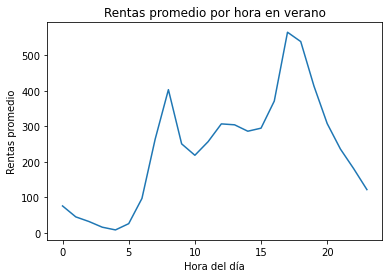

In [8]:
# Celda 2.3 - "season"=3 escriba su código y hallazgos 
bikes[bikes['season'] == 3].groupby('hour').total.mean().plot()
plt.title('Rentas promedio por hora en verano')
plt.xlabel('Hora del día')
plt.ylabel('Rentas promedio')
plt.show()

Se puede concluir que existen patrones claros en las horas que no se modifican por las estaciones, lo cual puede interpretarse debido a las rutinas laborales. Por ejemplo, una persona que llega a la oficina a las 9 am utilizará la bicicleta alrededor de las 8 am independientemente de la estación del año. Sin embargo, se observan diferencias en las escalas de uso entre las estaciones. En invierno, la cantidad promedio de alquileres baja significativamente, con un máximo de alrededor de 275 alquileres en la hora pico. En cambio, en verano, en la hora pico se alcanzan alrededor de 530 alquileres en promedio. Estas diferencias son claras debido a las condiciones climáticas. 

### Punto 3 - Regresión lineal
En la celda 3 ajuste un modelo de regresión lineal a todo el conjunto de datos, utilizando "total" como variable de respuesta y "season" y "hour" como las únicas variables predictoras, teniendo en cuenta que la variable "season" es categórica. Luego, imprima los coeficientes e interprételos. ¿Cuáles son las limitaciones de la regresión lineal en este caso?

In [9]:
import pandas as pd
import statsmodels.api as sm

# Crear variables dummy para la variable "season"
season_dummies = pd.get_dummies(bikes['season'], prefix='season', drop_first=True)

# Concatenar las variables dummy con el DataFrame original
bikes = pd.concat([bikes, season_dummies], axis=1)

# Ajustar el modelo de regresión lineal
X = bikes[['season_2', 'season_3', 'season_4', 'hour']]
X = sm.add_constant(X)  # Añadir una constante para el intercepto
y = bikes['total']
model = sm.OLS(y, X).fit()

# Imprimir los coeficientes del modelo
print(model.summary())



                            OLS Regression Results                            
Dep. Variable:                  total   R-squared:                       0.223
Model:                            OLS   Adj. R-squared:                  0.223
Method:                 Least Squares   F-statistic:                     782.5
Date:                Mon, 08 Apr 2024   Prob (F-statistic):               0.00
Time:                        00:17:01   Log-Likelihood:                -70669.
No. Observations:               10886   AIC:                         1.413e+05
Df Residuals:                   10881   BIC:                         1.414e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -6.4303      4.016     -1.601      0.1

In [10]:
# Crear un nuevo DataFrame para las variables predictoras
from sklearn.metrics import mean_squared_error

X = bikes[['season', 'hour']].copy()

# Crear variables dummy para la variable "season" y concatenarlas con el nuevo DataFrame
season_dummies = pd.get_dummies(X['season'], prefix='season', drop_first=True)
X = pd.concat([X.drop('season', axis=1), season_dummies], axis=1)

# Añadir una constante para el intercepto
X = sm.add_constant(X)

# Realizar predicciones con el modelo de regresión lineal
y_pred_linear = model.predict(X)

# Calcular el MSE para el modelo de regresión lineal
mse_linear = mean_squared_error(y, y_pred_linear)
print("MSE para el modelo de regresión lineal:", mse_linear)

MSE para el modelo de regresión lineal: 1439616.6505522835


La baja R^2 de 22.3% indica que el modelo de regresión lineal no puede explicar completamente la variabilidad en el número total de alquileres de bicicletas. Esto sugiere que la relación entre las variables predictoras y la variable de respuesta podría no ser estrictamente lineal, como se asume en la regresión lineal. Además, es posible que el modelo no esté capturando otros patrones más complejos, como efectos estacionales.

Para evitar problemas de multicolinealidad, se utilizó la dumificación con K-1 categorías. Es importante tener en cuenta que, a pesar de este enfoque, el modelo aún puede no ser adecuado para capturar la complejidad de los datos y puede subestimar la verdadera relación entre las variables.

Por lo tanto, sería prudente considerar la exploración de modelos más avanzados, como modelos de series temporales o modelos no lineales, que puedan capturar mejor la naturaleza no lineal de los datos y los posibles efectos estacionales. Estos modelos podrían mejorar significativamente la capacidad predictiva en comparación con el modelo de regresión lineal.

### Punto 4 - Árbol de decisión manual
En la celda 4 cree un árbol de decisiones para pronosticar la variable "total" iterando **manualmente** sobre las variables "hour" y  "season". El árbol debe tener al menos 6 nodos finales.

In [11]:
# Celda 4
# Lectura de la información de archivo .csv
bikes_modelo = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/bikeshare.csv', index_col='datetime', parse_dates=True)

# Renombrar variable "count" a "total"
bikes_modelo.rename(columns={'count':'total'}, inplace=True)

# Crear la hora como una variable 
bikes_modelo['hour'] = bikes.index.hour

# Visualización de los datos
bikes_modelo.tail()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total,hour
datetime,,,,,,,,,,,,
2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336,19
2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241,20
2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168,21
2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,12,117,129,22
2012-12-19 23:00:00,4,0,1,1,13.12,16.665,66,8.9981,4,84,88,23


In [12]:
# Selección de variables predictoras
feature_cols = ['season', 'hour']
feature_cols

['season', 'hour']

In [13]:
# Separación de variables predictoras (X) y variable de interes (y)
X = bikes_modelo[feature_cols]
y = bikes_modelo.total  # Variable de respuesta continua

In [14]:
# Definición de la función que calcula el error cuadrático medio
def mse(y):
    if y.shape[0] == 0:
        return 0
    else:
        return np.mean((y - y.mean()) ** 2)



In [15]:
# Definición de la función para calcular la ganancia de una variable predictora j dado el punto de corte k
def mse_impurity(X_col, y, split):
    filter_l = X_col < split
    y_l = y.loc[filter_l]
    y_r = y.loc[~filter_l]

    n_l = y_l.shape[0]
    n_r = y_r.shape[0]

    mse_y = mse(y)
    mse_l = mse(y_l)
    mse_r = mse(y_r)

    mse_impurity_ = mse_y - (n_l / (n_l + n_r) * mse_l + n_r / (n_l + n_r) * mse_r)

    return mse_impurity_



In [16]:
# Definición de la función best_split para calcular cuál es la mejor variable y punto de corte para hacer la bifurcación del árbol
def best_split(X, y, num_pct=10):
    features = range(X.shape[1])
    best_split = [0, 0, -np.inf]  # j, split, gain

    for j in features:
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]

        for split in splits:
            gain = mse_impurity(X.iloc[:, j], y, split)

            if gain > best_split[2]:
                best_split = [j, split, gain]

    return best_split




In [17]:
# Definición de la función tree_grow para hacer un crecimiento recursivo del árbol
def tree_grow(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10):
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], level=level, split=-1, n_samples=1, gain=0)
        return tree

    j, split, gain = best_split(X, y, num_pct)

    y_pred = y.mean()
    tree = dict(y_pred=y_pred, level=level, split=-1, n_samples=X.shape[0], gain=gain)

    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree

    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]

    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)

    return tree



In [18]:
# Definición de la función tree_predict para hacer predicciones según las variables 'X' y el árbol 'tree'
def tree_predict(X, tree):
    predicted = np.ones(X.shape[0]) * tree['y_pred']

    if tree['split'] != -1:
        j, split = tree['split']
        filter_l = (X.iloc[:, j] < split)
        X_l = X.loc[filter_l]
        X_r = X.loc[~filter_l]

        if X_l.shape[0] > 0:
            predicted[filter_l] = tree_predict(X_l, tree['sl'])
        if X_r.shape[0] > 0:
            predicted[~filter_l] = tree_predict(X_r, tree['sr'])

    return predicted



In [19]:
# Construcción y predicción del árbol
tree = tree_grow(X, y, level=0, min_gain=0.001, max_depth=3, num_pct=10)
predictions = tree_predict(X, tree)


In [20]:
predictions

array([ 25.17771982,  25.17771982,  25.17771982, ..., 152.47563353,
       152.47563353, 152.47563353])

In [21]:
from sklearn.metrics import mean_squared_error

# Calcular el MSE para las predicciones del árbol de decisión
mse_tree = mean_squared_error(y, predictions)
print("MSE para el árbol de decisión:", mse_tree)


MSE para el árbol de decisión: 17392.935521570682


In [22]:
def count_nodes(tree):
    if tree['split'] == -1:
        # Si es un nodo hoja, retorna 1
        return 1
    else:
        # Si no es un nodo hoja, cuenta los nodos en los subárboles izquierdo y derecho
        return 1 + count_nodes(tree['sl']) + count_nodes(tree['sr'])

# Contar el número de nodos en el árbol manual
num_nodes = count_nodes(tree)
print("Número de nodos en el árbol manual:", num_nodes)


Número de nodos en el árbol manual: 15


In [23]:
# Calcular SST
SST = sum((y - np.mean(y)) ** 2)

# Calcular R^2
r2 = 1 - (mse_tree / SST)
print("Coeficiente de determinación R^2 para el árbol de decisión manual:", r2)


Coeficiente de determinación R^2 para el árbol de decisión manual: 0.999951303878722


### Punto 5 - Árbol de decisión con librería
En la celda 5 entrene un árbol de decisiones con la **librería sklearn**, usando las variables predictoras "season" y "hour" y calibre los parámetros que considere conveniente para obtener un mejor desempeño. Recuerde dividir los datos en conjuntos de entrenamiento y validación para esto. Comente el desempeño del modelo con alguna métrica de desempeño de modelos de regresión y compare desempeño con el modelo del punto 3.

In [33]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

feature_cols = ['season', 'hour']
X = bikes_modelo[feature_cols]
y = bikes_modelo.total  # Variable de respuesta continua

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Instanciar y entrenar el modelo
regressor = DecisionTreeRegressor(max_depth=7, random_state=42)
regressor.fit(X_train, y_train)

# Hacer predicciones
y_pred = regressor.predict(X_test)

# Calcular el error cuadrático medio
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Para obtener la importancia de las características
print("Feature Importances:", regressor.feature_importances_)



Mean Squared Error: 13870.786495571638
Feature Importances: [0.13387087 0.86612913]


In [34]:
from sklearn.metrics import r2_score

# Calcular R^2
r2 = r2_score(y_test, y_pred)
print("Coeficiente de determinación R^2:", r2)


Coeficiente de determinación R^2: 0.5737350742814777


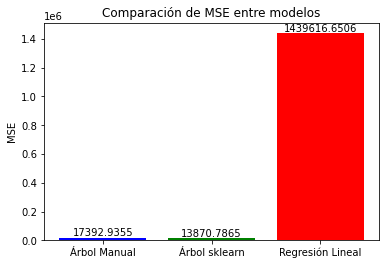

In [35]:
import matplotlib.pyplot as plt

# Valores de MSE para cada modelo
mse_values = [mse_tree, mse, mse_linear]

# Nombres de los modelos
model_names = ['Árbol Manual', 'Árbol sklearn', 'Regresión Lineal']

# Crear el gráfico de barras
bars = plt.bar(model_names, mse_values, color=['blue', 'green', 'red'])

# Añadir título y etiquetas para los ejes
plt.title('Comparación de MSE entre modelos')
plt.ylabel('MSE')

# Añadir el valor numérico encima de cada barra
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.005, round(yval, 4), ha='center', va='bottom')

# Mostrar el gráfico
plt.show()



La mejora en el desempeño de los árboles de decisión en comparación con el modelo lineal es significativa. El árbol de decisión construido manualmente muestra un rendimiento superior al modelo de `sklearn`, con un total de 15 nodos. Sin embargo, es importante destacar que el coeficiente de determinación \( R^2 \) obtenido para el árbol manual es de 0.99, mientras que para el árbol de `sklearn` es de 0.44 con un `max_depth` de 3, y aumenta a 0.57 al ajustarlo a 7. 

Al considerar el error cuadrático medio (MSE), observamos una mejora significativa en el árbol de `sklearn`, que pasó a tener un MSE de 13870, mientras que el árbol manual tuvo un MSE de 17392 y el modelo de regresión lineal, el peor de los tres, tuvo un MSE de 1439616. Esta mejora indica que los árboles de decisión están mejorando la capacidad de ajuste a los datos en comparación con el modelo lineal.

La diferencia en los resultados de \( R^2 \) puede atribuirse al hecho de que en el árbol manual se utilizan todos los datos para construir el modelo, lo que puede resultar en un sobreajuste (overfitting). Esto significa que el modelo se ajusta demasiado a los datos de entrenamiento y puede no generalizar bien a nuevos datos. Para obtener una evaluación más precisa del rendimiento de los modelos, es recomendable dividir los datos en conjuntos de entrenamiento y prueba, y evaluar los modelos en el conjunto de prueba para verificar su capacidad de generalización a nuevos datos.

## Parte B - Métodos de ensamblajes
En esta parte del taller se usará el conjunto de datos de Popularidad de Noticias Online. El objetivo es predecir si la notica es popular o no, la popularidad está dada por la cantidad de reacciones en redes sociales. Para más detalles puede visitar el siguiente enlace: [datos](https://archive.ics.uci.edu/ml/datasets/online+news+popularity).

### Datos popularidad de noticias

In [26]:
# Lectura de la información de archivo .csv
df = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/mashable.csv', index_col=0)
df.head()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,Popular
0,http://mashable.com/2014/12/10/cia-torture-rep...,28.0,9.0,188.0,0.732620,1.0,0.844262,5.0,1.0,1.0,...,0.200000,0.80,-0.487500,-0.60,-0.250000,0.9,0.8,0.4,0.8,1
1,http://mashable.com/2013/10/18/bitlock-kicksta...,447.0,7.0,297.0,0.653199,1.0,0.815789,9.0,4.0,1.0,...,0.160000,0.50,-0.135340,-0.40,-0.050000,0.1,-0.1,0.4,0.1,0
2,http://mashable.com/2013/07/24/google-glass-po...,533.0,11.0,181.0,0.660377,1.0,0.775701,4.0,3.0,1.0,...,0.136364,1.00,0.000000,0.00,0.000000,0.3,1.0,0.2,1.0,0
3,http://mashable.com/2013/11/21/these-are-the-m...,413.0,12.0,781.0,0.497409,1.0,0.677350,10.0,3.0,1.0,...,0.100000,1.00,-0.195701,-0.40,-0.071429,0.0,0.0,0.5,0.0,0
4,http://mashable.com/2014/02/11/parking-ticket-...,331.0,8.0,177.0,0.685714,1.0,0.830357,3.0,2.0,1.0,...,0.100000,0.55,-0.175000,-0.25,-0.100000,0.0,0.0,0.5,0.0,0


In [27]:
# Definición variable de interes y variables predictoras
X = df.drop(['url', 'Popular'], axis=1)
y = df['Popular']
y.mean()

0.5

In [28]:
# División de la muestra en set de entrenamiento y prueba
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

### Punto 6 - Árbol de decisión y regresión logística
En la celda 6 construya un árbol de decisión y una regresión logística. Para el árbol calibre al menos un parámetro y evalúe el desempeño de cada modelo usando las métricas de Accuracy y F1-Score.

In [29]:
# Celda 6
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

# Construcción y entrenamiento del árbol de decisión
tree = DecisionTreeClassifier(max_depth=5, random_state=1)
tree.fit(X_train, y_train)

# Construcción y entrenamiento de la regresión logística
log_reg = LogisticRegression(max_iter=1000, random_state=1)
log_reg.fit(X_train, y_train)



LogisticRegression(max_iter=1000, random_state=1)

In [30]:
# Predicciones con el árbol de decisión
y_pred_tree = tree.predict(X_test)

# Predicciones con la regresión logística
y_pred_log_reg = log_reg.predict(X_test)

# Evaluación del desempeño con Accuracy y F1-Score para el árbol de decisión
accuracy_tree = accuracy_score(y_test, y_pred_tree)
f1_score_tree = f1_score(y_test, y_pred_tree)

# Evaluación del desempeño con Accuracy y F1-Score para la regresión logística
accuracy_log_reg = accuracy_score(y_test, y_pred_log_reg)
f1_score_log_reg = f1_score(y_test, y_pred_log_reg)

# Impresión de los resultados
print("Árbol de decisión - Accuracy:", accuracy_tree, "F1-Score:", f1_score_tree)
print("Regresión logística - Accuracy:", accuracy_log_reg, "F1-Score:", f1_score_log_reg)


Árbol de decisión - Accuracy: 0.6373333333333333 F1-Score: 0.6616915422885573
Regresión logística - Accuracy: 0.6193333333333333 F1-Score: 0.6064782908339076


### Punto 7 - Votación Mayoritaria
En la celda 7 elabore un esamble con la metodología de **Votación mayoritaria** compuesto por 300 muestras bagged para cada uno de los siguientes escenarios:

-100 árboles de decisión donde max_depth tome un valor de su elección\
-100 árboles de decisión donde min_samples_leaf tome un valor de su elección\
-100 regresiones logísticas

Evalúe cada uno de los tres modelos de manera independiente utilizando las métricas de Accuracy y F1-Score, luego evalúe el ensamble de modelos y compare los resultados. 

In [31]:
# Celda 7
from sklearn.ensemble import BaggingClassifier


In [32]:
# 100 árboles de decisión con max_depth
tree_max_depth = DecisionTreeClassifier(max_depth=5, random_state=1)
bagged_tree_max_depth = BaggingClassifier(base_estimator=tree_max_depth, n_estimators=100, random_state=1)
bagged_tree_max_depth.fit(X_train, y_train)

# 100 árboles de decisión con min_samples_leaf
tree_min_samples_leaf = DecisionTreeClassifier(min_samples_leaf=4, random_state=1)
bagged_tree_min_samples_leaf = BaggingClassifier(base_estimator=tree_min_samples_leaf, n_estimators=100, random_state=1)
bagged_tree_min_samples_leaf.fit(X_train, y_train)

# 100 regresiones logísticas
log_reg = LogisticRegression(max_iter=1000, random_state=1)
bagged_log_reg = BaggingClassifier(base_estimator=log_reg, n_estimators=100, random_state=1)
bagged_log_reg.fit(X_train, y_train)


BaggingClassifier(base_estimator=LogisticRegression(max_iter=1000,
                                                    random_state=1),
                  n_estimators=100, random_state=1)

In [33]:
# Predicciones y evaluación para el árbol de decisión con max_depth
y_pred_tree_max_depth = bagged_tree_max_depth.predict(X_test)
accuracy_tree_max_depth = accuracy_score(y_test, y_pred_tree_max_depth)
f1_score_tree_max_depth = f1_score(y_test, y_pred_tree_max_depth)

# Predicciones y evaluación para el árbol de decisión con min_samples_leaf
y_pred_tree_min_samples_leaf = bagged_tree_min_samples_leaf.predict(X_test)
accuracy_tree_min_samples_leaf = accuracy_score(y_test, y_pred_tree_min_samples_leaf)
f1_score_tree_min_samples_leaf = f1_score(y_test, y_pred_tree_min_samples_leaf)

# Predicciones y evaluación para la regresión logística
y_pred_log_reg = bagged_log_reg.predict(X_test)
accuracy_log_reg = accuracy_score(y_test, y_pred_log_reg)
f1_score_log_reg = f1_score(y_test, y_pred_log_reg)


In [34]:
from sklearn.ensemble import VotingClassifier

# Crear el ensamble de modelos
ensemble = VotingClassifier(estimators=[
    ('tree_max_depth', bagged_tree_max_depth),
    ('tree_min_samples_leaf', bagged_tree_min_samples_leaf),
    ('log_reg', bagged_log_reg)
], voting='hard')

# Entrenar el ensamble
ensemble.fit(X_train, y_train)

# Realizar predicciones y evaluar el ensamble
y_pred_ensemble = ensemble.predict(X_test)
accuracy_ensemble = accuracy_score(y_test, y_pred_ensemble)
f1_score_ensemble = f1_score(y_test, y_pred_ensemble)

# Imprimir los resultados
print("Árbol de decisión con max_depth - Accuracy:", accuracy_tree_max_depth, "F1-Score:", f1_score_tree_max_depth)
print("Árbol de decisión con min_samples_leaf - Accuracy:", accuracy_tree_min_samples_leaf, "F1-Score:", f1_score_tree_min_samples_leaf)
print("Regresión logística - Accuracy:", accuracy_log_reg, "F1-Score:", f1_score_log_reg)
print("Ensamble de modelos - Accuracy:", accuracy_ensemble, "F1-Score:", f1_score_ensemble)



Árbol de decisión con max_depth - Accuracy: 0.66 F1-Score: 0.6599999999999999
Árbol de decisión con min_samples_leaf - Accuracy: 0.646 F1-Score: 0.6490416391275612
Regresión logística - Accuracy: 0.6153333333333333 F1-Score: 0.6039807824296499
Ensamble de modelos - Accuracy: 0.6513333333333333 F1-Score: 0.6515656229180546


### Punto 8 - Votación Ponderada
En la celda 8 elabore un ensamble con la metodología de **Votación ponderada** compuesto por 300 muestras bagged para los mismos tres escenarios del punto 7. Evalúe los modelos utilizando las métricas de Accuracy y F1-Score

In [35]:
# Celda 8
from sklearn.ensemble import VotingClassifier


In [36]:
# Crear el ensamble de modelos con votación ponderada
ensemble_weighted = VotingClassifier(estimators=[
    ('tree_max_depth', bagged_tree_max_depth),
    ('tree_min_samples_leaf', bagged_tree_min_samples_leaf),
    ('log_reg', bagged_log_reg)
], voting='soft', weights=[1, 1, 1])  # Puedes ajustar los pesos según desees

# Entrenar el ensamble
ensemble_weighted.fit(X_train, y_train)


VotingClassifier(estimators=[('tree_max_depth',
                              BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=5,
                                                                                      random_state=1),
                                                n_estimators=100,
                                                random_state=1)),
                             ('tree_min_samples_leaf',
                              BaggingClassifier(base_estimator=DecisionTreeClassifier(min_samples_leaf=4,
                                                                                      random_state=1),
                                                n_estimators=100,
                                                random_state=1)),
                             ('log_reg',
                              BaggingClassifier(base_estimator=LogisticRegression(max_iter=1000,
                                                                                  ra

In [37]:
# Realizar predicciones y evaluar el ensamble ponderado
y_pred_ensemble_weighted = ensemble_weighted.predict(X_test)
accuracy_ensemble_weighted = accuracy_score(y_test, y_pred_ensemble_weighted)
f1_score_ensemble_weighted = f1_score(y_test, y_pred_ensemble_weighted)

# Imprimir los resultados
print("Ensamble de modelos con votación ponderada - Accuracy:", accuracy_ensemble_weighted, "F1-Score:", f1_score_ensemble_weighted)


Ensamble de modelos con votación ponderada - Accuracy: 0.652 F1-Score: 0.6556728232189973


### Punto 9 - Comparación y análisis de resultados
En la celda 9 comente sobre los resultados obtenidos con las metodologías usadas en los puntos 7 y 8, compare los resultados y enuncie posibles ventajas o desventajas de cada una de ellas.

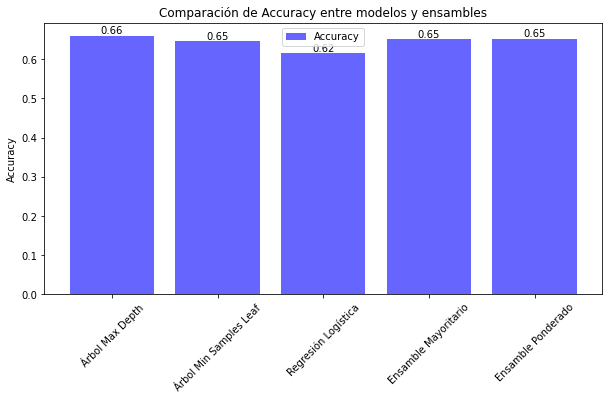

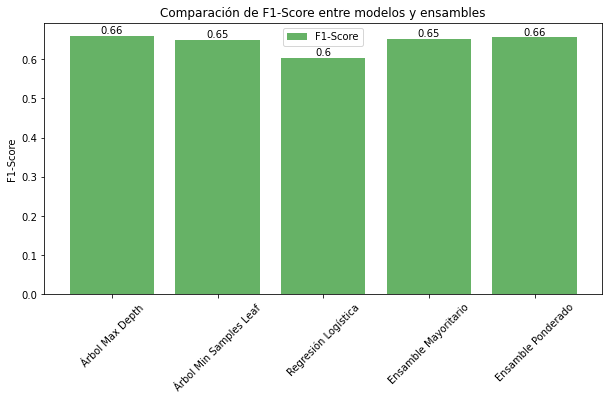

In [38]:
import matplotlib.pyplot as plt

# Datos de los modelos
model_names = ['Árbol Max Depth', 'Árbol Min Samples Leaf', 'Regresión Logística', 'Ensamble Mayoritario', 'Ensamble Ponderado']
accuracies = [accuracy_tree_max_depth, accuracy_tree_min_samples_leaf, accuracy_log_reg, accuracy_ensemble, accuracy_ensemble_weighted]
f1_scores = [f1_score_tree_max_depth, f1_score_tree_min_samples_leaf, f1_score_log_reg, f1_score_ensemble, f1_score_ensemble_weighted]

# Crear el gráfico de barras para Accuracy
plt.figure(figsize=(10, 5))
bars_accuracy = plt.bar(model_names, accuracies, color='blue', alpha=0.6, label='Accuracy')
plt.ylabel('Accuracy')
plt.title('Comparación de Accuracy entre modelos y ensambles')
plt.xticks(rotation=45)
plt.legend()

# Añadir etiquetas de valor encima de cada barra
for bar in bars_accuracy:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

plt.show()

# Crear el gráfico de barras para F1-Score
plt.figure(figsize=(10, 5))
bars_f1_score = plt.bar(model_names, f1_scores, color='green', alpha=0.6, label='F1-Score')
plt.ylabel('F1-Score')
plt.title('Comparación de F1-Score entre modelos y ensambles')
plt.xticks(rotation=45)
plt.legend()

# Añadir etiquetas de valor encima de cada barra
for bar in bars_f1_score:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

plt.show()



En este análisis, se compararon diferentes modelos para predecir la popularidad de artículos en base a características del contenido. El árbol de decisión con restricción de profundidad máxima demostró tener el mejor desempeño, logrando un equilibrio entre precisión (Accuracy) y la métrica F1-Score, ambas con un valor de 0.66. Esta restricción ayuda a prevenir el sobreajuste, lo que puede explicar su éxito en este caso. Sin embargo, es importante elegir cuidadosamente la profundidad máxima para evitar modelos demasiado simplificados o complejos.

Por otro lado, la regresión logística tuvo el rendimiento más bajo con un Accuracy de 0.62 y un F1-Score de 0.60. Aunque este modelo es más simple y fácil de interpretar, puede no ser adecuado para capturar relaciones complejas entre las variables, lo que podría explicar su menor desempeño en comparación con los árboles de decisión.

En cuanto a los ensambles de modelos, aunque tiene resultados un poco mas bajops que el max con 0.65, generalmente ofrecen la ventaja de mejorar la estabilidad y la precisión de las predicciones combinando las fortalezas de varios modelos. Sin embargo, esto viene con un aumento en la complejidad computacional y una disminución en la interpretabilidad.
